# RTF Model for predicting zone with Energy

### Model Description
This notebook implements a Random Forest (RTF) model to classify the impact zone (C, S, V) of a racket based on sound features extracted from .wav audio files. The workflow involves reading audio samples, computing the frequency spectrum using FFT, and **extracting energy per frequency band**. These features are then normalized and padded to ensure consistent input dimensions. The model is trained using the processed data and evaluated using accuracy metrics on both training and test sets. Hyperparameters such as the number of estimators, max depth, and minimum samples per split are tuned across multiple configurations.

# Import Libraries

In [13]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys
from sklearn.ensemble import RandomForestClassifier


### Import Tools Functions

In [9]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Readwav function

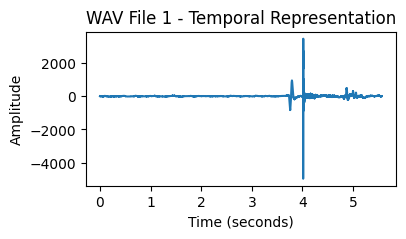

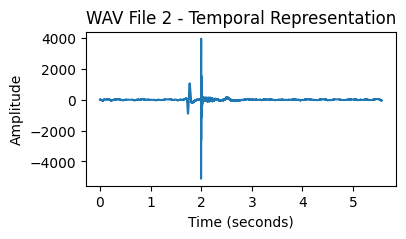

In [10]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

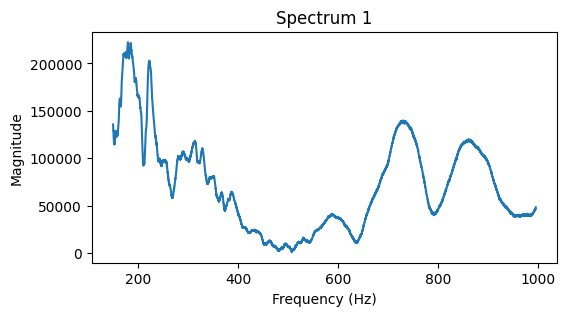

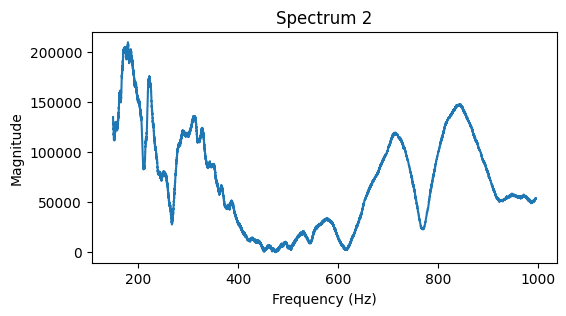

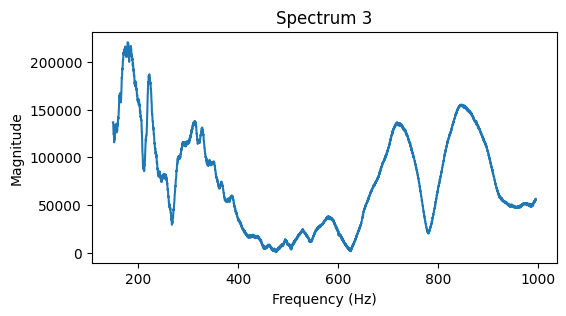

In [11]:
from spectrumFromSignal import spectrumFromSignal


spectrumVect=[]

for i in range(len(testWavFileVect)):
    spectrum,freqs= spectrumFromSignal(testWavFileVect[i],samplerateVect[i])
    spectrumVect.append(spectrum)

for idx, spectrum in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs[:len(spectrum)], spectrum)  # Associate frequencies with the spectrum
    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()



Energy

In [12]:
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum

# Main

### Data Preparation and Label Encoding

In [27]:
import re
from readWavFolder import readWavFolder
from spectrumFromWav import spectrumFromWav
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum
# Liste des types de raquettes et zones
racket_names = {"RB": 1, "RO": 2, "RR": 3, "RV": 4}
zone_names = {"C": 1, "S": 2, "V": 3}

results = []


for band_width in range(20,21, 5):
    X_Hz = []
    X_Amplitude = []
    Y_Label = []
    print("band width :", band_width)

    for raquetteType in racket_names:
        dossier_raquette = f"../../../Data/Sound/P1"
        samplerateVect, WavFileVect, filesName = readWavFolder(dossier_raquette)

        for i in range(len(WavFileVect)):
            filename = filesName[i]

            # Utilisation de regex pour extraire la zone
            match = re.search(r'_(C|S|V)_', filename)
            if match:
                zone = match.group(1)
            else:
                continue  # Fichier ignoré s'il ne contient pas une zone valide

            wav_data = WavFileVect[i]

            # Gérer mono/stéréo sans modifier les fonctions
            if wav_data.ndim == 1:
                wav_data = np.stack((wav_data, wav_data), axis=-1)
            elif wav_data.shape[1] == 1:
                wav_data = np.concatenate((wav_data, wav_data), axis=1)

            #wav_channel = wav_data[:, [c]]
            spectrum = spectrumFromWav(wav_data)

            freqs = np.fft.fftfreq(len(spectrum) * 2, d=1 / samplerateVect[i])[:len(spectrum)]
            mask = (freqs >= 150) & (freqs <= 1000)
            filtered_freqs = freqs[mask]
            filtered_spectrum = spectrum[mask]

            band_energies, band_frequencies = energy_per_frequency_band_from_spectrum(
                filtered_spectrum,
                filtered_freqs,
                band_width
            )

            X_Hz.append(band_frequencies)
            X_Amplitude.append(band_energies)
            Y_Label.append(zone)

    # Normalisation
    X_Amplitude = [
        amp / np.max(amp) if np.max(amp) != 0 else amp
        for amp in X_Amplitude
    ]

    # Padding
    max_length = max(
        max(len(peaks) for peaks in X_Hz),
        max(len(amps) for amps in X_Amplitude)
    )
    X_Hz_padded = [np.pad(peaks, (0, max_length - len(peaks)), constant_values=0) for peaks in X_Hz]
    X_Amplitude_padded = [np.pad(amps, (0, max_length - len(amps)), constant_values=0) for amps in X_Amplitude]

    X = np.hstack((np.array(X_Hz_padded), np.array(X_Amplitude_padded)))
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    n_estimators_range = range(10, 101, 10)
    max_depth_range = [None, 10, 20, 30, 40]
    min_samples_split_range = [2, 5, 10]

    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rf.fit(X_train, y_train)

                y_pred = rf.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)
                accuracy_train = accuracy_score(y_train, rf.predict(X_train))

                channel_name = "Left" if c == 0 else "Right"

                results.append({
                    'Chanel_Name': channel_name,
                    'band_width': band_width,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })

# Export des résultats
results_df = pd.DataFrame(results)
#results_df.to_excel("RTF_ZONE_P1_Energie.xlsx", index=False)
#print("Results have been saved to 'RTF_ZONE_P1_Energie.xlsx'.")
print("DONE")

band width : 20
DONE


## Results and Visualisation

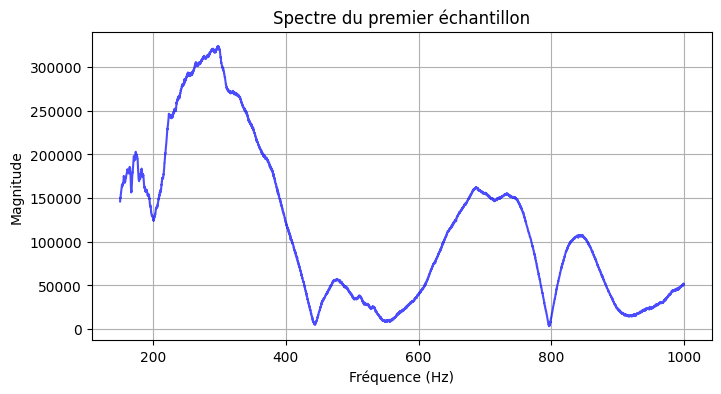

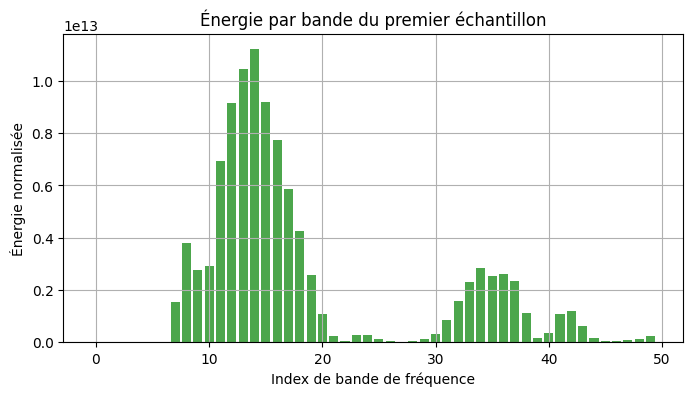

In [29]:
# Afficher le spectre du premier échantillon
plt.figure(figsize=(8, 4))
plt.plot(filtered_freqs, np.abs(filtered_spectrum), color='blue', alpha=0.7)
plt.title("Spectre du premier échantillon")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

# Afficher l'énergie par bande pour le premier échantillon
plt.figure(figsize=(8, 4))
plt.bar(range(len(band_energies)), band_energies, color='green', alpha=0.7)
plt.title("Énergie par bande du premier échantillon")
plt.xlabel("Index de bande de fréquence")
plt.ylabel("Énergie normalisée")
plt.grid(True)
plt.show()


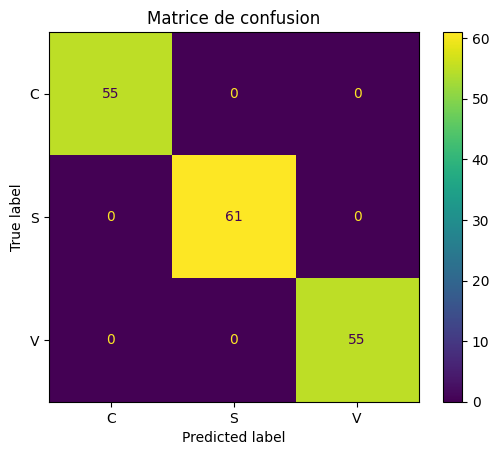

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
